# Join stock DataFrames and calculate returns

Our first step towards calculating modern portfolio theory (MPT) portfolios is to get daily and monthly returns. Eventually we're going to get the best portfolios of each month based on the Sharpe ratio. The easiest way to do this is to put all our stock prices into one DataFrame, then to resample them to the daily and monthly time frames. We need daily price changes to calculate volatility, which we will use as our measure of risk.

In [1]:
import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from pandas_datareader import DataReader
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [9,8]

In [2]:
stocklist = ['PETR4.SA', 'VALE', 'ITUB4.SA']

start = datetime(2002,3,21)
end = datetime(2020,7,24)

stocks = DataReader(stocklist, 'yahoo',start, end)['Adj Close'].dropna()
stocks.head()

Symbols,PETR4.SA,VALE,ITUB4.SA
Date,,,
2002-03-21,5.066937,0.850885,2.088810
2002-03-22,5.002308,0.824098,2.077610
2002-03-25,4.885975,0.824098,2.072008
2002-03-26,4.947158,0.845842,2.088919
2002-03-27,5.006616,0.858763,2.111207


In [3]:
# Resample the full dataframe to monthly timeframe
monthly_df = stocks.resample('BMS').first()

# Calculate daily returns of stocks
returns_daily = stocks.pct_change()

# Calculate monthly returns of the stocks
returns_monthly = monthly_df.pct_change().dropna()
print(returns_monthly.tail())

Symbols     PETR4.SA      VALE  ITUB4.SA
Date                                    
2020-03-02 -0.058552 -0.136975 -0.016572
2020-04-01 -0.460988 -0.206427 -0.328296
2020-05-01  0.215450 -0.020859  0.023571
2020-06-01  0.169735  0.233083  0.081563
2020-07-01  0.067880  0.044715  0.103778


# Calculate covariances for volatility

In [4]:
# Daily covariance of stocks (for each monthly period)
covariances = {}
rtd_idx = returns_daily.index
for i in returns_monthly.index:    
    # Mask daily returns for each month and year, and calculate covariance
    mask = (rtd_idx.month == i.month) & (rtd_idx.year == i.year)
    
    # Use the mask to get daily returns for the current month and year of monthy returns index
    covariances[i] = returns_daily[mask].cov()

print(covariances[i])

Symbols   PETR4.SA      VALE  ITUB4.SA
Symbols                               
PETR4.SA  0.000357  0.000307  0.000315
VALE      0.000307  0.000531  0.000252
ITUB4.SA  0.000315  0.000252  0.000508


# Calculate portfolios

In [5]:
portfolio_returns, portfolio_volatility, portfolio_weights = {}, {}, {}

# Get portfolio performances at each month
for date in sorted(covariances.keys()):
    cov = covariances[date]
    for portfolio in range(5000):
        weights = np.random.random(3)
        weights /= np.sum(weights) # /= divides weights by their sum to normalize
        returns = np.dot(weights, returns_monthly.loc[date])
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
        portfolio_returns.setdefault(date, []).append(returns)
        portfolio_volatility.setdefault(date, []).append(volatility)
        portfolio_weights.setdefault(date, []).append(weights)
        
print(portfolio_weights[date][0])

[0.06696384 0.38707329 0.54596287]


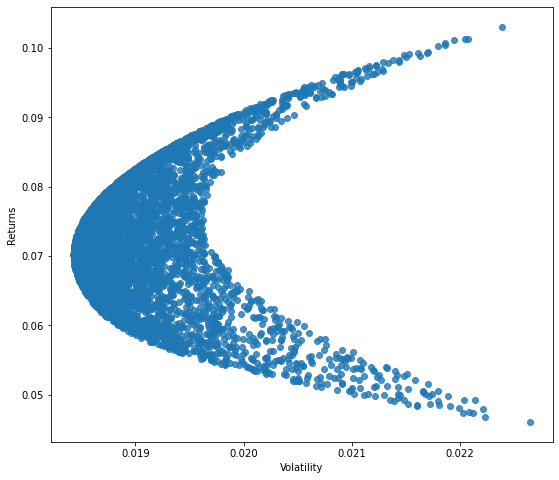

In [6]:
# Get latest date of available data
date = sorted(covariances.keys())[-1]  

# Plot efficient frontier
# warning: this can take at least 10s for the plot to execute...
plt.scatter(x=portfolio_volatility[date], y=portfolio_returns[date],  alpha=0.8)
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.show()

# Get best Sharpe ratios

In [7]:
# Empty dictionaries for sharpe ratios and best sharpe indexes by date
sharpe_ratio, max_sharpe_idxs = {}, {}

# Loop through dates and get sharpe ratio for each portfolio
for date in portfolio_returns.keys():
    for i, ret in enumerate(portfolio_returns[date]):
    
        # Divide returns by the volatility for the date and index, i
        sharpe_ratio.setdefault(date, []).append(ret / portfolio_volatility[date][i])

    # Get the index of the best sharpe ratio for each date
    max_sharpe_idxs[date] = np.argmax(sharpe_ratio[date])

print(portfolio_returns[date][max_sharpe_idxs[date]])

0.1011427003209603


# Calculate EWMAs

We will now work towards creating some features to be able to predict our ideal portfolios. We will simply use the price movement as a feature for now. To do this we will create a daily exponentially-weighted moving average (EWMA), then resample that to the monthly timeframe. Finally, we'll shift the monthly moving average of price one month in the future, so we can use it as a feature for predicting future portfolios.

In [8]:
# Calculate exponentially-weighted moving average of daily returns
ewma_daily = returns_daily.ewm(span=30).mean()

# Resample daily returns to first business day of the month with the first day for that month
ewma_monthly = ewma_daily.resample('BMS').first()

# Shift ewma for the month by 1 month forward so we can use it as a feature for future predictions 
ewma_monthly = ewma_monthly.shift(1).dropna()

print(ewma_monthly.iloc[-1])

Symbols
PETR4.SA    0.008091
VALE        0.008815
ITUB4.SA    0.003001
Name: 2020-07-01 00:00:00, dtype: float64


# Make features and targets

To use machine learning to pick the best portfolio, we need to generate features and targets. Our features were just created in the last exercise – the exponentially weighted moving averages of prices. Our targets will be the best portfolios we found from the highest Sharpe ratio.

In [9]:
targets, features = [], []

# Create features from price history and targets as ideal portfolio
for date, ewma in ewma_monthly.iterrows():

    # Get the index of the best sharpe ratio
    best_idx = max_sharpe_idxs[date]
    targets.append(portfolio_weights[date][best_idx])
    features.append(ewma)  # add ewma to features

targets = np.array(targets)
features = np.array(features)
print(targets[-5:])

[[1.65010001e-02 2.91446796e-04 9.83207553e-01]
 [6.07564177e-03 9.63002008e-01 3.09223507e-02]
 [9.66756653e-01 2.15765663e-03 3.10856906e-02]
 [3.24369586e-02 9.66459541e-01 1.10350069e-03]
 [5.85629128e-02 9.02767156e-03 9.32409416e-01]]


# Plot efficient frontier with best Sharpe ratio

Let's now plot the efficient frontier again, but add a marker for the portfolio with the best Sharpe index. Visualizing our data is always a good idea to better understand it.

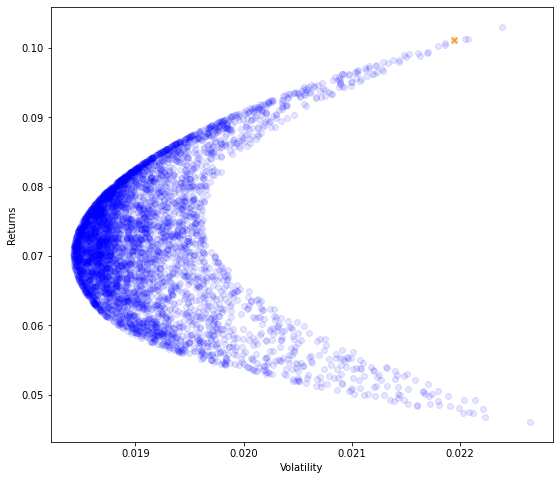

In [10]:
# Get most recent (current) returns and volatility
date = sorted(covariances.keys())[-1]
cur_returns = portfolio_returns[date]
cur_volatility = portfolio_volatility[date]

# Plot efficient frontier with sharpe as point
plt.scatter(x=cur_volatility, y=cur_returns, alpha=0.1, color='blue')
best_idx = max_sharpe_idxs[date]

# Place an orange "X" on the point with the best Sharpe ratio
plt.scatter(x=cur_volatility[best_idx], y=cur_returns[best_idx], marker='x', color='orange')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.show()

# Make predictions with a random forest

In order to fit a machine learning model to predict ideal portfolios, we need to create train and test sets for evaluating performance.

In [11]:
from sklearn.ensemble import RandomForestRegressor

# Make train and test features
train_size = int(0.85 * features.shape[0])
train_features = features[:train_size]
test_features = features[train_size:]
train_targets = targets[:train_size]
test_targets = targets[train_size:]

# Fit the model and check scores on train and test
rfr = RandomForestRegressor(n_estimators=300, random_state=42)
rfr.fit(train_features, train_targets)
print(rfr.score(train_features, train_targets))
print(rfr.score(test_features, test_targets))

0.854332451221305
-0.17588962379107753


# Get predictions and first evaluation

Now that we have a trained random forest model (rfr), we want to use it to get predictions on the test set. We do this to evaluate our model's performance – at a basic level, is it doing as well or better than just buying the bank Itaú?

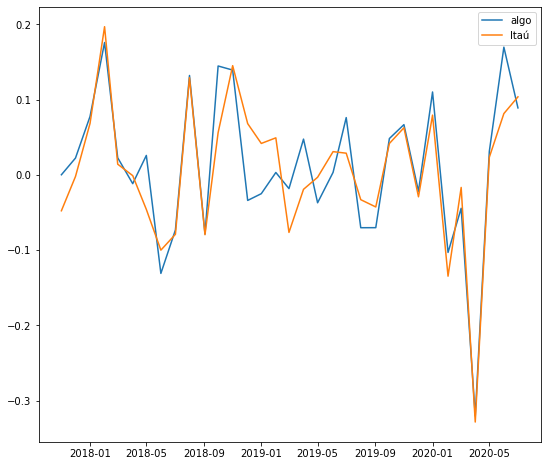

In [12]:
# Get predictions from model on train and test
train_predictions = rfr.predict(train_features)
test_predictions = rfr.predict(test_features)

# Calculate and plot returns from our RF predictions and the SPY returns
test_returns = np.sum(returns_monthly.iloc[train_size:] * test_predictions, axis=1)
plt.plot(test_returns, label='algo')
plt.plot(returns_monthly['ITUB4.SA'].iloc[train_size:], label='Itaú')
plt.legend()
plt.show()

# Evaluate returns

Let's now see how our portfolio selection would perform as compared with just investing in the SPY. We'll do this to see if our predictions are promising, despite the low R2 value.

We will set a starting value for our investment of $1000, then loop through the returns from our predictions as well as from Itaú. We'll use the monthly returns from our portfolio selection and Itaú and apply them to our starting cash balance. From this we will get a month-by-month picture of how our investment is doing, and we can see how our predictions did overall vs the Itaú. Next, we can plot our portfolio from our predictions and compare it to Itaú.

In [13]:
# Calculate the effect of our portfolio selection on a hypothetical $1k investment
cash = 1000
algo_cash, itau_cash = [cash], [cash]  # set equal starting cash amounts
for r in test_returns:
    cash *= 1 + r
    algo_cash.append(cash)

# Calculate performance for SPY
cash = 1000  # reset cash amount
for r in returns_monthly['ITUB4.SA'].iloc[train_size:]:
    cash *= 1 + r
    itau_cash.append(cash)

print('algo returns:', (algo_cash[-1] - algo_cash[0]) / algo_cash[0])
print('Itaú returns:', (itau_cash[-1] - itau_cash[0]) / itau_cash[0])

algo returns: 0.1995892236601426
Itaú returns: 0.029758655435877926


# Plot returns

Lastly, we'll plot the performance of our machine-learning-generated portfolio versus just holding the Itaú. We can use this as an evaluation to see if our predictions are doing well or not.

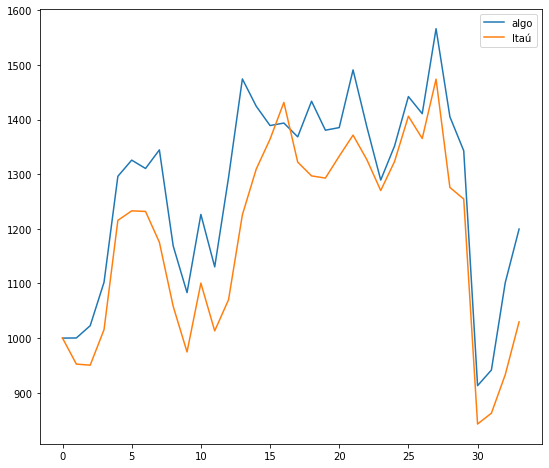

In [14]:
# Plot the algo_cash and spy_cash to compare overall returns
plt.plot(algo_cash, label='algo')
plt.plot(itau_cash, label='Itaú')
plt.legend()  # show the legend
plt.show()